<a href="https://colab.research.google.com/github/Data-for-Good-by-UF/AIR/blob/main/LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# load libraries
# Author: Yuko Matsumoto
# Title: LSTM_RNN
# Date: July 7, 2021

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.options.display.max_columns=200

from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

! pip install pmdarima
import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
from pmdarima.arima.utils import nsdiffs

# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [27]:
# file path
read_data = "pollution_us_2000_2016.csv"

# read the dataset
df = pd.read_csv(read_data)

# drop the first column as it indicate just row numbers
df.drop("Unnamed: 0",axis=1,inplace=True)
df.head()

,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Units,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,3.000000,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN
1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,3.000000,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0
2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,2.975000,6.6,23,NaN,Parts per million,1.145833,4.2,21,NaN
3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,2.975000,6.6,23,NaN,Parts per million,0.878947,2.2,23,25.0
4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-02,Parts per billion,22.958333,36.0,19,34,Parts per million,0.013375,0.032,10,27,Parts per billion,1.958333,3.0,22,4.0,Parts per million,0.850000,1.6,23,NaN


In [28]:
# drop duplicate rows
df.drop_duplicates(inplace=True)

In [29]:
df.isna().sum()

State Code                0
County Code               0
Site Num                  0
Address                   0
State                     0
County                    0
City                      0
Date Local                0
NO2 Units                 0
NO2 Mean                  0
NO2 1st Max Value         0
NO2 1st Max Hour          0
NO2 AQI                   0
O3 Units                  0
O3 Mean                   0
O3 1st Max Value          0
O3 1st Max Hour           0
O3 AQI                    0
SO2 Units                 0
SO2 Mean                  0
SO2 1st Max Value         0
SO2 1st Max Hour          0
SO2 AQI              870344
CO Units                  0
CO Mean                   0
CO 1st Max Value          0
CO 1st Max Hour           0
CO AQI               870988
dtype: int64

In [30]:
# convert Date local to python date and time 
df['date'] =  pd.to_datetime(df['Date Local'])

# check descriptive statistics for date
df['date'].describe(datetime_is_numeric=True)

count                          1741629
mean     2008-10-12 22:57:38.410464768
min                2000-01-01 00:00:00
25%                2004-11-20 00:00:00
50%                2009-01-31 00:00:00
75%                2012-11-07 00:00:00
max                2016-05-31 00:00:00
Name: date, dtype: object

In [31]:
# compute mean AQI for each citiy for each date
mean_aqi = df.groupby(['City','date'])[['NO2 AQI','O3 AQI','SO2 AQI','CO AQI']].mean()

# check new data frame
mean_aqi.head(3)

NO2 AQI  O3 AQI  SO2 AQI  CO AQI
City        date                                        
Albuquerque 2011-01-01     19.0    30.0      0.0     2.0
            2011-01-02     38.0    28.0      1.0     7.0
            2011-01-03     44.0    14.0      3.0    13.0

In [32]:
# reset index mean_aqi 
mean_aqi = mean_aqi.reset_index()

In [33]:
# select one single city for analysis and for developing proof of concepts
city = 'Washington'

# select one column for analysis and for developing proof of concepts
col = 'O3 AQI'

In [34]:
# create subset of dataset to include only city and column selected for analysis
ts = mean_aqi.loc[mean_aqi['City'] == 'Washington',['date',col]]

# check data
ts.head(3)

,date,O3 AQI
335183,2000-01-01,12.0
335184,2000-01-02,25.0
335185,2000-01-03,22.0


In [35]:
# create time series from data frame
ts = ts.set_index('date')

# check data
ts.head(3)

,O3 AQI
date,
2000-01-01,12.0
2000-01-02,25.0
2000-01-03,22.0


In [36]:
# resample time series to Daily Frequency
# resample ensures that all dates from begining to end of the start series are present
# use ffill  forward fill to handle missing valye filling the missing value from the previous day
ts = ts.resample('D').mean().ffill()
ts.head(3)

,O3 AQI
date,
2000-01-01,12.0
2000-01-02,25.0
2000-01-03,22.0


In [37]:
ts.shape

(5965, 1)

In [38]:
ts

,O3 AQI
date,
2000-01-01,12.0
2000-01-02,25.0
2000-01-03,22.0
2000-01-04,20.0
2000-01-05,21.0
...,...
2016-04-26,51.0
2016-04-27,29.0
2016-04-28,27.0


In [39]:
dataset_train = pd.read_csv('pollution_us_2000_2016.csv')

In [40]:
training_set = ts.iloc[:, 0:2].values

In [41]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 2))
training_set_scaled = sc.fit_transform(training_set)

In [42]:
training_set_scaled

array([[0.10731707],
       [0.23414634],
       [0.20487805],
       ...,
       [0.25365854],
       [0.21463415],
       [0.27317073]])

In [43]:
X_train = []
y_train = []
for i in range(60, 2035):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train

array([[[0.10731707],
        [0.23414634],
        [0.20487805],
        ...,
        [0.18536585],
        [0.21463415],
        [0.17560976]],

       [[0.23414634],
        [0.20487805],
        [0.18536585],
        ...,
        [0.21463415],
        [0.17560976],
        [0.17560976]],

       [[0.20487805],
        [0.18536585],
        [0.19512195],
        ...,
        [0.17560976],
        [0.17560976],
        [0.17560976]],

       ...,

       [[0.29268293],
        [0.3902439 ],
        [0.28292683],
        ...,
        [0.45853659],
        [0.30243902],
        [0.51707317]],

       [[0.3902439 ],
        [0.28292683],
        [0.31219512],
        ...,
        [0.30243902],
        [0.51707317],
        [0.45853659]],

       [[0.28292683],
        [0.31219512],
        [0.30243902],
        ...,
        [0.51707317],
        [0.45853659],
        [0.8097561 ]]])

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [45]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
62/62 [==============================] - 34s 126ms/step - loss: 0.0567
Epoch 2/100
62/62 [==============================] - 8s 124ms/step - loss: 0.0361
Epoch 3/100
62/62 [==============================] - 8s 125ms/step - loss: 0.0377
Epoch 4/100
62/62 [==============================] - 8s 124ms/step - loss: 0.0332
Epoch 5/100
62/62 [==============================] - 8s 124ms/step - loss: 0.0369
Epoch 6/100
62/62 [==============================] - 8s 125ms/step - loss: 0.0380
Epoch 7/100
62/62 [==============================] - 8s 125ms/step - loss: 0.0331
Epoch 8/100
62/62 [==============================] - 8s 125ms/step - loss: 0.0389
Epoch 9/100
62/62 [==============================] - 8s 125ms/step - loss: 0.0301
Epoch 10/100
62/62 [==============================] - 8s 124ms/step - loss: 0.0355
Epoch 11/100
62/62 [==============================] - 8s 127ms/step - loss: 0.0339
Epoch 12/100
62/62 [==============================] - 8s 128ms/step - loss: 0.0295
Epoch 13/100

In [46]:
dataset_test = pd.read_csv('pollution_us_2000_2016.csv')
real_stock_price = dataset_test.iloc[:, 17:18].values
dataset_test = dataset_test['O3 AQI']
dataset_test

0          34
1          34
2          34
3          34
4          27
           ..
1746656    44
1746657    44
1746658    44
1746659    44
1746660    44
Name: O3 AQI, Length: 1746661, dtype: int64

In [47]:

dataset_total = pd.concat((dataset_train['O3 AQI'], dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_AQI = regressor.predict(X_test)
predicted_AQI = sc.inverse_transform(predicted_AQI)

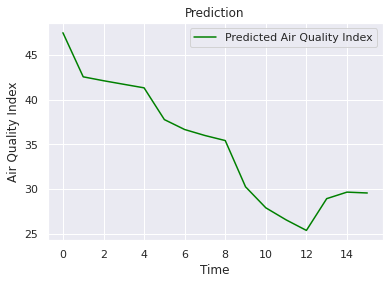

In [48]:

# plt.plot(real_stock_price, color = 'black', label = 'Air Quality Index')
plt.plot(predicted_AQI, color = 'green', label = 'Predicted Air Quality Index')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Air Quality Index')
plt.legend()
plt.show()